# An initial look at the Harry Potter theme

## Introduction

Harry Potter was always my favourite Lego theme, and now that it's back (to witches and wizards and magical beasts!) I've grabbed the database of lego sets and parts from [Rebrickable](https://rebrickable.com/downloads/) and had a look at how the theme has changed over the years. It also gave me a chance to do some visualisation with [Altair](https://altair-viz.github.io/), which is awesome.

## Libraries and setup

In [1]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [2]:
DB_PATH = Path("../../data/db")

In [3]:
!ls {DB_PATH}

20190511115712.log  lego.db


In [4]:
conn = sqlite3.connect(str(DB_PATH / "lego.db"))

## Datasets

The data was downloaded from [Rebrickable](https://rebrickable.com/downloads/) and accurate as of 2019-05-08. I wrote a Python script to create a SQLite version of the original Rebrickable database using the provided scheme - you can download it [here](), along with the Jupyter Notebooks with the source code for most of this post (once I get around to committing them...).

I made a few minor changes to the data:
- I dropped four sets ([K4706-1](https://rebrickable.com/sets/K4706-1/sorcerers-stone-kit/), [K4701-1](https://rebrickable.com/sets/K4701-1/chamber-of-secrets-kit/), [K4729-1](https://rebrickable.com/sets/K4729-1/deluxe-hogwarts-kit/) and [5000068-1](https://rebrickable.com/sets/5000068-1/harry-potter-classic-kit/)). These are collections of other sets which were released separately and shouldn't be considered sets in their own right.
- I renamed the *Sorcerer's Stone* subtheme to *Philosopher's Stone*.
- Some sets have duplicate names e.g. Hogwarts, Hogwarts Express. These were renamed.

In [5]:
theme_order = ["Philosopher's Stone", "Chamber of Secrets", "Prisoner of Azkaban", "Goblet of Fire",
              "Order of the Phoenix", "Harry Potter", "Fantastic Beasts"]

### Related to subthemes and sets

In [6]:
cols = "sets.name, sets.set_num, sets.year, sets.num_parts, themes.name as theme_name"

hp_themes_df = pd.read_sql_query(
    f"""SELECT {cols} FROM sets
    JOIN themes on sets.theme_id = themes.id
    WHERE themes.name = 'Harry Potter'
        OR themes.name LIKE '%Sorcerer''s Stone%'
        OR themes.name = 'Chamber of Secrets'
        OR themes.name = 'Prisoner of Azkaban'
        OR themes.name = 'Goblet of Fire'
        OR themes.name = 'Order of the Phoenix'
        OR themes.name = 'Fantastic Beasts'""",
    conn)

In [7]:
hp_themes_df = hp_themes_df[hp_themes_df['year']!=2019]

In [8]:
hp_themes_df.head()

,name,set_num,year,num_parts,theme_name
0,Diagon Alley,10217-1,2011,2031,Harry Potter
1,Trolley,30110-1,2011,22,Harry Potter
2,The Lab,30111-1,2011,34,Harry Potter
3,Mini Hogwarts Express,40028-1,2011,64,Harry Potter
4,Freeing Dobby,4736-1,2010,73,Harry Potter


### Related to parts and colours

In [9]:
cols = """sets.set_num, sets.name, sets.year, sets.num_parts, color_id,
        parts.part_num, inventory_parts.quantity, colors.rgb, colors.is_trans, colors.name as color_name,
        themes.name as theme_name, inventories.id as inv_id, parts.name as part_name"""

hp_parts_df = pd.read_sql_query(
    f"""SELECT {cols} FROM sets
    JOIN themes on sets.theme_id = themes.id
    JOIN inventories on sets.set_num = inventories.set_num
    JOIN inventory_parts on inventories.id = inventory_parts.inventory_id
    JOIN parts on inventory_parts.part_num = parts.part_num
    JOIN colors on inventory_parts.color_id = colors.id
    WHERE themes.name = 'Harry Potter'
        OR themes.name LIKE '%Sorcerer''s Stone%'
        OR themes.name = 'Chamber of Secrets'
        OR themes.name = 'Prisoner of Azkaban'
        OR themes.name = 'Goblet of Fire'
        OR themes.name = 'Order of the Phoenix'
        OR themes.name = 'Fantastic Beasts'
        AND sets.year != 2019""",
    conn)

In [10]:
hp_parts_df.head(5)

,set_num,name,year,num_parts,color_id,part_num,quantity,rgb,is_trans,color_name,theme_name,inv_id,part_name
0,10132-1,Motorized Hogwarts Express,2004,712,72,2039,2,6C6E68,f,Dark Bluish Gray,Prisoner of Azkaban,10570,Lamp Post 2 x 2 x 7 with 6 Base Flutes
1,10132-1,Motorized Hogwarts Express,2004,712,4,2357,2,C91A09,f,Red,Prisoner of Azkaban,10570,Brick 2 x 2 Corner
2,10132-1,Motorized Hogwarts Express,2004,712,72,2357,21,6C6E68,f,Dark Bluish Gray,Prisoner of Azkaban,10570,Brick 2 x 2 Corner
3,10132-1,Motorized Hogwarts Express,2004,712,4,2377,2,C91A09,f,Red,Prisoner of Azkaban,10570,Window 1 x 2 x 2 Plane
4,10132-1,Motorized Hogwarts Express,2004,712,72,2412b,11,6C6E68,f,Dark Bluish Gray,Prisoner of Azkaban,10570,Tile Special 1 x 2 Grille with Bottom Groove


## Global data cleaning and new features

There are four sets ([K4706-1](https://rebrickable.com/sets/K4706-1/sorcerers-stone-kit/), [K4701-1](https://rebrickable.com/sets/K4701-1/chamber-of-secrets-kit/), [K4729-1](https://rebrickable.com/sets/K4729-1/deluxe-hogwarts-kit/) and [5000068-1](https://rebrickable.com/sets/5000068-1/harry-potter-classic-kit/)) under the *Harry Potter* theme that are collections of other sets. I haven't included them here as they aren't really sets in their own right.

In [11]:
dfs = [hp_themes_df, hp_parts_df]

for df in dfs:
    # Drop collections
    df.drop(df[df['set_num'].isin(['K4706-1', 'K4701-1', 'K4729-1', '5000068-1'])]\
            .index, axis=0, inplace=True)
    
    # Fixes identically named sets
    # Changes 'Sorcerer's Stone' to 'Philosopher's Stone'
    df.loc[df['theme_name']=="Sorcerer's Stone", 'theme_name'] = "Philosopher's Stone"
    df.loc[(df['name']=='Hogwarts Castle') & (df['theme_name']=='Order of the Phoenix'), 'name'] = 'Hogwarts (Third Edition)'
    df.loc[(df['name']=='Hogwarts Castle') & (df['theme_name']=="Sorcerer's Stone"), 'name'] = 'Hogwarts (First Edition)'
    df.loc[(df['name']=='Diagon Alley') & (df['theme_name']=='Harry Potter'), 'name'] = 'Diagon Alley'
    df.loc[(df['name']=='Diagon Alley') & (df['theme_name']=='Fantastic Beasts'), 'name'] = 'Diagon Alley (micro)'
    df.loc[(df['name']=='Hogwarts Express') & (df['theme_name']=="Philosopher's Stone"), 'name'] = 'Hogwarts Express (1st Edition)'
    df.loc[(df['name']=='Hogwarts Express') & (df['theme_name']=='Fantastic Beasts'), 'name'] = 'Hogwarts Express (4th Edition)'
    
    # Combines set_num and name columns
    # Set number is uniquely identifying but opaque
    df['num_name'] = df['set_num'] + ": " + df["name"]

### Year

In [12]:
# Compute count of sets by year
hp_yearsets_df = hp_themes_df[['year', 'theme_name', 'name']]\
    .groupby(['theme_name', 'year'], as_index=False)['name']\
    .count()\
    .rename(columns={'name': 'year_count'})

# Compute count of sets by theme
hp_themesets_df = hp_themes_df[['theme_name', 'name']]\
    .groupby(['theme_name'], as_index=False)['name']\
    .count()\
    .rename(columns={'name': 'set_count'})

# Combine datasets
hp_yearsets_df = hp_yearsets_df.merge(hp_themesets_df, on="theme_name", how="left")

hp_yearsets_df.head(10)

,theme_name,year,year_count,set_count
0,Chamber of Secrets,2002,8,10
1,Chamber of Secrets,2003,2,10
2,Fantastic Beasts,2018,12,12
3,Goblet of Fire,2005,5,5
4,Harry Potter,2002,6,21
5,Harry Potter,2010,6,21
6,Harry Potter,2011,7,21
7,Harry Potter,2018,2,21
8,Order of the Phoenix,2007,1,1
9,Philosopher's Stone,2001,11,14


### Parts

In [13]:
# Get name of set with most parts per theme
most_parts = hp_themes_df\
    .groupby('theme_name')['num_name', 'num_parts']\
    .apply(lambda grp: grp.nlargest(1, 'num_parts'))\
    .reset_index()[['theme_name', 'num_name']]\
    .rename(columns={'num_name': 'most_parts'})

hp_themes_df = hp_themes_df.merge(most_parts, on="theme_name", how="right")

### Colours

For each part in a set, the db gives information about its colour and quantity e.g.:

In [14]:
hp_parts_df[['name', 'color_name', 'part_name', 'quantity']].head(1)

,name,color_name,part_name,quantity
0,Motorized Hogwarts Express,Dark Bluish Gray,Lamp Post 2 x 2 x 7 with 6 Base Flutes,2


For investigating changes in the colour palette, this was expanded so each row represented a discrete color-part pair:

In [15]:
hp_colors_df = hp_parts_df\
    .reindex(hp_parts_df.index.repeat(hp_parts_df['quantity']))

# For plots, the rgb value needs to be a valid hex color code with # prefix
hp_colors_df['hex'] = '#' + hp_colors_df['rgb']

# Example expanded colour df
hp_colors_df[['name', 'color_name', 'part_name']].head(2)

,name,color_name,part_name
0,Motorized Hogwarts Express,Dark Bluish Gray,Lamp Post 2 x 2 x 7 with 6 Base Flutes
0,Motorized Hogwarts Express,Dark Bluish Gray,Lamp Post 2 x 2 x 7 with 6 Base Flutes


In [16]:
# Create different groupings of colour counts:

# By year
colors_count_year = hp_colors_df.groupby(['year', 'color_name', 'hex'], as_index=False)\
    .count()[['year', 'hex', 'quantity', 'color_name']]
colors_count_year['transparent'] = colors_count_year['hex'].isin(list(hp_colors_df[hp_colors_df['is_trans'] == 't']['hex']))

# By theme
colors_count_theme = hp_colors_df.groupby(['theme_name', 'color_name', 'hex'], as_index=False)\
    .count()[['theme_name', 'hex', 'quantity', 'color_name']]
colors_count_theme['transparent'] = colors_count_theme['hex'].isin(list(hp_colors_df[hp_colors_df['is_trans'] == 't']['hex']))

# By set
colors_count_set = hp_colors_df.groupby(['theme_name', 'num_name', 'name', 'color_name', 'hex'], as_index=False)\
    .count()[['theme_name', 'num_name', 'name', 'hex', 'quantity', 'color_name', 'num_parts']]
colors_count_set['transparent'] = colors_count_set['hex'].isin(list(hp_colors_df[hp_colors_df['is_trans'] == 't']['hex']))

In [17]:
# Size of the palette
# By year
colors_number_year = hp_parts_df.groupby(['year'])['color_name']\
    .nunique()\
    .reset_index(name='color_count')\
    .rename(columns={'color_name': 'color_count'})

# By theme
colors_number_theme = hp_parts_df.groupby(['theme_name'])['color_name']\
    .nunique()\
    .reset_index(name='color_count')\
    .rename(columns={'color_name': 'color_count'})

# By set
colors_number_set = hp_parts_df.groupby(['set_num'])['color_name']\
    .nunique()\
    .reset_index(name='color_count')\
    .rename(columns={'color_name': 'color_count'})

## Sets released by year

The film adaptation of Harry Potter and the Philosopher's Stone was released in 2001 and Lego had the license to release tie-in sets under, obviously, the *Philosopher's (Sorcerer's) Stone* subtheme. This trend of releasing sets to coincide with, or shortly after, the release of a film continued for several years. However, massive financial problems at Lego meant that the number of sets released under the theme declined sharply after 2004, with only a single set ([5378-1: Hogwarts Castle](https://brickset.com/sets/5378-1/Hogwarts-Castle)) being released in 2007. This culminated with the theme being discontinued after 2007.

Luckily for those of us who liked the theme, it was only to be a temporary hiatus. The theme returned in 2010, with new sets released under the general *Harry Potter* theme rather than the film-specific structure of the past. That said, set [4840-1: The Burrow](https://brickset.com/sets/4840-1/The-Burrow), along with [4867-1: Hogwarts](https://rebrickable.com/sets/4867-1/hogwarts/) and [4865-1: The Forbidden Forest](https://rebrickable.com/sets/4865-1/the-forbidden-forest/), were based on events in *Half-Blood Prince* and *Deathly Hallows* respectively.

Then, in 2011, the theme got hit with Avada Kedavra and discontinued for a second time. Like Harry in the Forbidden Forest though it wasn't truly dead and returned unexpectedly in 2018 with a large range of new sets. While the revival is listed in Rebrickable's database under the *Fantastic Beasts* theme, and was happened between the first and second films, only three sets to date (and some collectable minifigures) are actually from the film. The majority are based on the events in *Philosopher's Stone* and *Chamber of Azkaban*, with some scenes from *Prisoner of Azkaban* represented in [75955-1: Hogwarts Express](https://brickset.com/sets/75955-1/Hogwarts-Express). 2019 is bringing more, continuing *Prisoner of Azkaban* and introducing sets from *Goblet of Fire*. None announced so far relate to the Fantastic Beasts franchise...


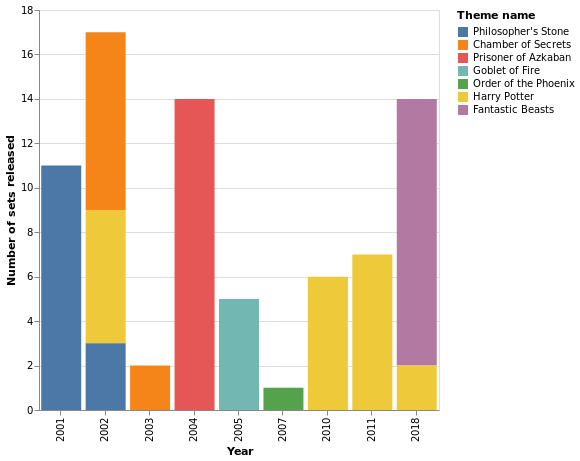

In [18]:
plot_sets_year = alt.Chart(hp_yearsets_df).mark_bar().encode(
    x=alt.X('year:O', title='Year'),
    y=alt.Y('year_count:Q', title='Number of sets released'),
    color=alt.Color('theme_name:N', title='Theme name', sort=theme_order),
    tooltip=alt.Tooltip(['set_count:Q'], title='Total sets in theme')
).properties(
    width=400,
    height=400
)

plot_sets_year.save('hp_plt_sets_year.html')

plot_sets_year

In [19]:
hp_themes_df[(hp_themes_df['theme_name']=='Harry Potter') & (hp_themes_df['year']==2011)]

,name,set_num,year,num_parts,theme_name,num_name,most_parts
0,Diagon Alley,10217-1,2011,2031,Harry Potter,10217-1: Diagon Alley,10217-1: Diagon Alley
1,Trolley,30110-1,2011,22,Harry Potter,30110-1: Trolley,10217-1: Diagon Alley
2,The Lab,30111-1,2011,34,Harry Potter,30111-1: The Lab,10217-1: Diagon Alley
3,Mini Hogwarts Express,40028-1,2011,64,Harry Potter,40028-1: Mini Hogwarts Express,10217-1: Diagon Alley
10,The Forbidden Forest,4865-1,2011,64,Harry Potter,4865-1: The Forbidden Forest,10217-1: Diagon Alley
11,The Knight Bus,4866-1,2011,281,Harry Potter,4866-1: The Knight Bus,10217-1: Diagon Alley
12,Hogwarts,4867-1,2011,465,Harry Potter,4867-1: Hogwarts,10217-1: Diagon Alley


## Number of parts

### Number of parts by year

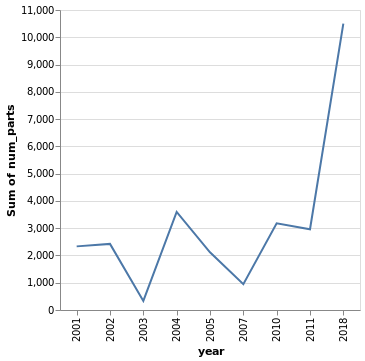

In [20]:
alt.Chart(hp_themes_df).mark_line().encode(
    x='year:O',
    y='sum(num_parts):Q'
).properties(
    height=300,
    width=300
)

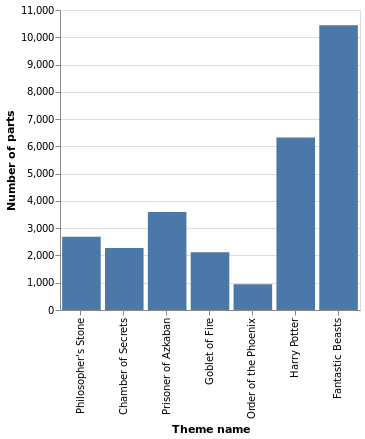

In [21]:
alt.Chart(hp_themes_df).mark_bar().encode(
    x=alt.X('theme_name:O', title='Theme name', sort=theme_order),
    y=alt.Y('sum(num_parts):Q', title='Number of parts'),
    tooltip=alt.Tooltip(["most_parts:N"], title="Set with most parts")
).properties(
    height=300,
    width=300
)

The Fantastic Beasts theme is skewed almost entirely by the 6020 part [71043-1: Hogwarts Castle](https://rebrickable.com/sets/71043-1/hogwarts-castle) set (listed here as 6016 parts for...some reason). Removing it perhaps creates a better comparison of the themes in general.

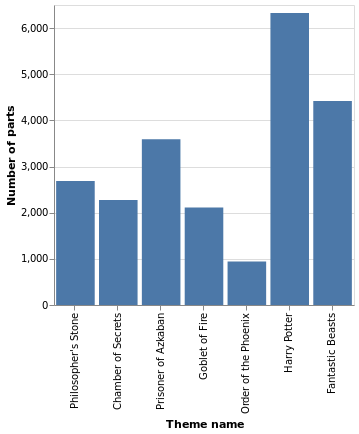

In [22]:
alt.Chart(hp_themes_df[hp_themes_df['set_num']!='71043-1']).mark_bar().encode(
    x=alt.X('theme_name:O', title='Theme name', sort=theme_order),
    y=alt.Y('sum(num_parts):Q', title='Number of parts'),
    tooltip=alt.Tooltip(["most_parts:N"], title="Set with most parts")
).properties(
    height=300,
    width=300
)

In [23]:
hp_themes_df.groupby('theme_name')['name', 'num_parts'].apply(lambda grp: grp.nlargest(5, 'num_parts')).reset_index().drop('level_1', axis=1)

,theme_name,name,num_parts
0,Chamber of Secrets,Chamber of Secrets,597
1,Chamber of Secrets,Dumbledore's Office,451
2,Chamber of Secrets,Escape from Privet Drive,282
3,Chamber of Secrets,Knockturn Alley,211
4,Chamber of Secrets,Aragog in the Dark Forest,183
5,Fantastic Beasts,Hogwarts Castle,6016
6,Fantastic Beasts,Hogwarts Great Hall,882
7,Fantastic Beasts,Hogwarts Express (4th Edition),805
8,Fantastic Beasts,Hogwarts Whomping Willow,756
9,Fantastic Beasts,Newt's Case of Magical Creatures,694


## Colours

### Size of the colour palette

The plots below show the total number of different colours of parts in sets released by both year and subtheme.

In [24]:
colors_number_year = colors_number_year.merge(
    hp_themes_df.groupby(['year'])['num_parts'].sum().reset_index()
)

colors_number_set = colors_number_set.merge(
    hp_themes_df[['set_num', 'num_parts', 'num_name']]
)
colors_number_set['log_num_parts'] = np.log(colors_number_set['num_parts'])

In [25]:
hp_themes_df.groupby(['year'])['num_parts'].sum().reset_index()

,year,num_parts
0,2001,2333
1,2002,2424
2,2003,332
3,2004,3594
4,2005,2114
5,2007,945
6,2010,3176
7,2011,2961
8,2018,10499


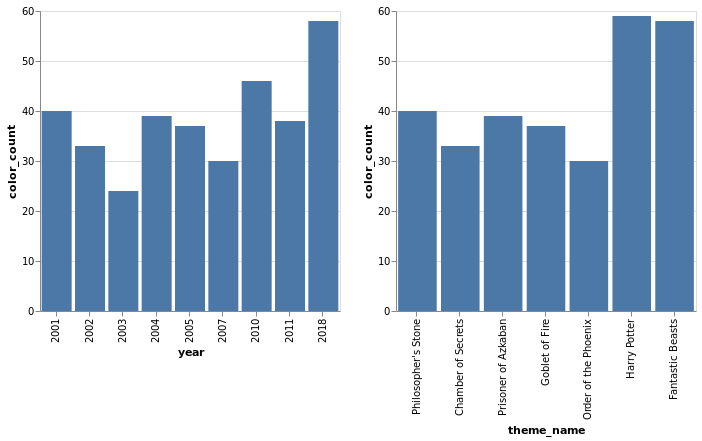

In [26]:
year_colors = alt.Chart(colors_number_year).mark_bar().encode(
    x='year:N',
    y='color_count:Q'
).properties(
    height=300,
    width=300
)

theme_colors = alt.Chart(colors_number_theme).mark_bar().encode(
    x=alt.X('theme_name:N', sort=theme_order),
    y='color_count:Q'
).properties(
    height=300,
    width=300
)

year_colors | theme_colors

Sets in the *Harry Potter* and *Fantastic Beasts* themes have more colours in their palettes. However, recall that sets in these themes also have the largest parts count. The below plot shows both the part count (log transformed) and the number of colours. The two variables are positively correlated ($r$ = 0.845).

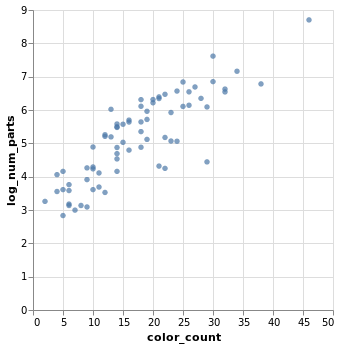

In [27]:
alt.Chart(colors_number_set).mark_circle().encode(
    x='color_count:Q',
    y='log_num_parts:Q',
    tooltip='num_name:N'
).properties(
    height=300,
    width=300
)

In [28]:
colors_number_set[['color_count', 'log_num_parts']].corr(method='pearson')

,color_count,log_num_parts
color_count,1.000000,0.845327
log_num_parts,0.845327,1.000000


### Colour by year

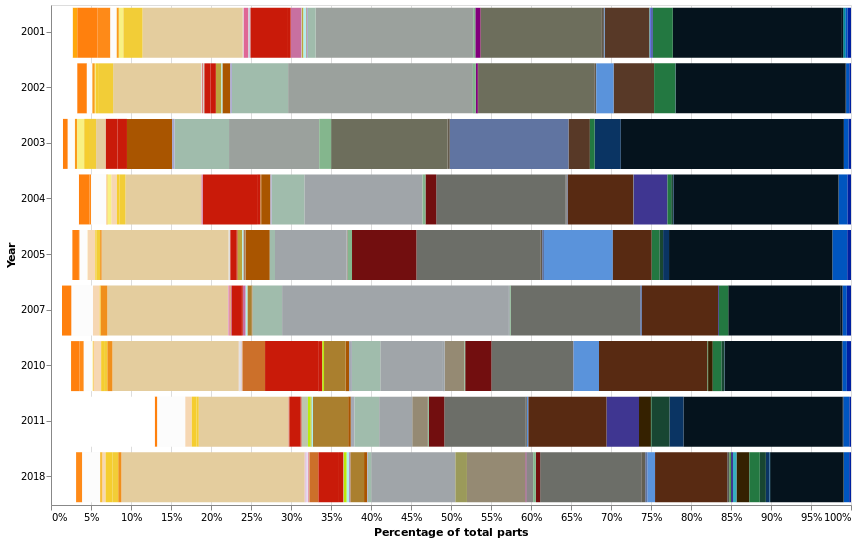

In [29]:
click = alt.selection_multi(encodings=['color'])

alt.Chart(colors_count_year).mark_bar().encode(
    x=alt.X('sum(quantity)', stack="normalize", axis=alt.Axis(format='%', title='Percentage of total parts')),
    y=alt.Y("year:O", title='Year'),
    color=alt.condition(click, alt.Color("hex:N", scale=None), alt.value('lightgray')),
    tooltip=(['color_name', 'quantity', 'transparent:N'])
).properties(
    height=500,
    width=800
).add_selection(click).interactive()

### Colour by theme

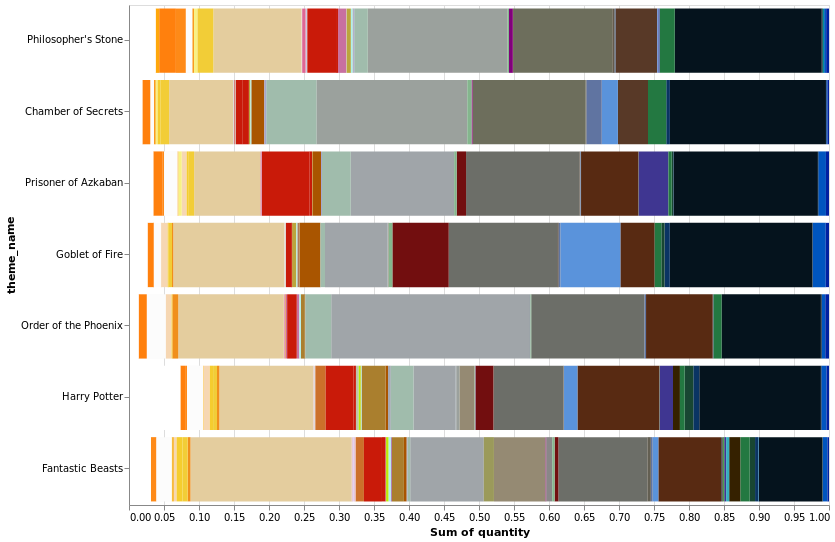

In [30]:
click = alt.selection_multi(encodings=['color'])

alt.Chart(colors_count_theme).mark_bar().encode(
    x=alt.X('sum(quantity)', stack="normalize"),
    y=alt.Y("theme_name:O", sort=theme_order),
    color=alt.condition(click, alt.Color("hex:N", scale=None), alt.value('lightgray')),
    tooltip=(['color_name', 'quantity', 'transparent:N'])
).properties(
    height=500,
    width=700
).add_selection(click).interactive()

### Colour by set

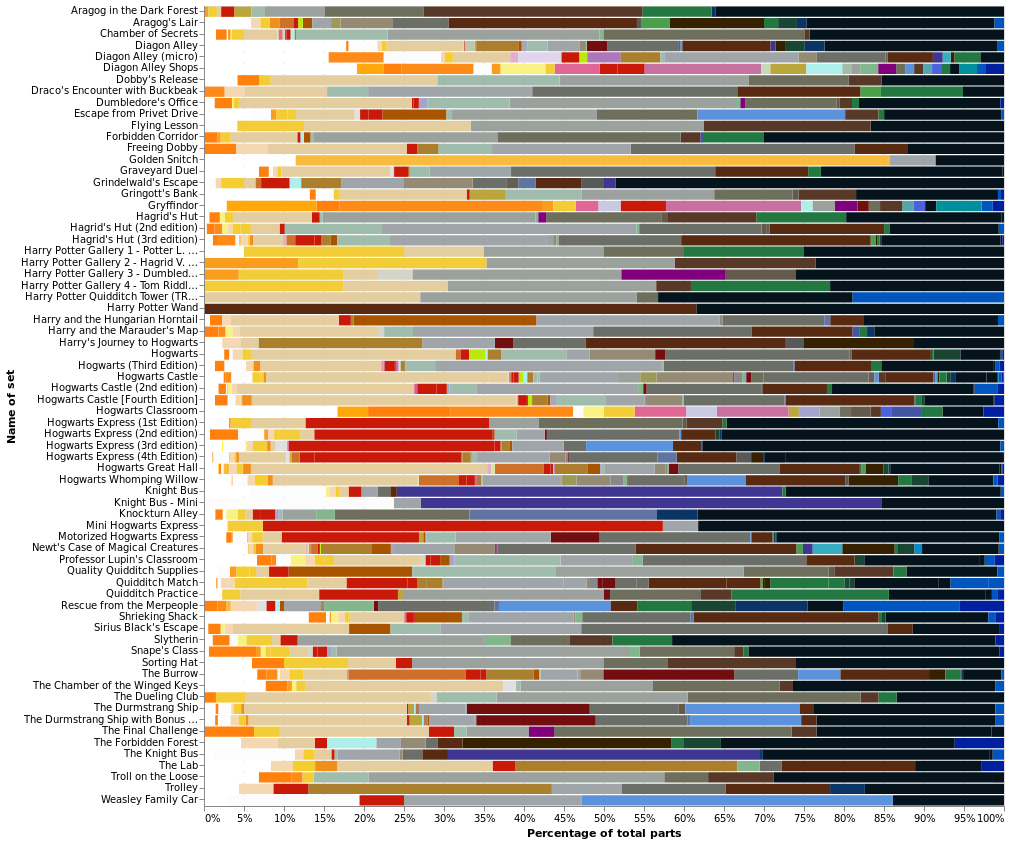

In [31]:
click = alt.selection_multi(encodings=['color'])

alt.Chart(colors_count_set).mark_bar().encode(
    x=alt.X('sum(quantity)', stack="normalize", axis=alt.Axis(format='%', title='Percentage of total parts')),
    y=alt.Y("name:O", title='Name of set'),
    color=alt.condition(click, alt.Color("hex:N", scale=None), alt.value('lightgray')),
    tooltip=[
        alt.Tooltip('num_name:N', title='Set name'),
        alt.Tooltip('theme_name:N', title='Theme'),
        alt.Tooltip('color_name:N', title='Color'),
        alt.Tooltip('quantity:Q', title='Quantity'),
        alt.Tooltip('transparent:N', title='Transparent')
    ]
).properties(
    height=800,
    width=800
).add_selection(click).interactive()